# pytorch 및 mask_rcnn 관련 import

In [1]:
import os

import matplotlib.pyplot as plt

from PIL import Image, ImageDraw

import torch

import numpy as np

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.data.transforms import build_transforms
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list

# caffe glog 로깅 레벨 설정 및 caffe 및 tools 관련 import
os.environ['GLOG_minloglevel'] = '3'

# for model debugging log
from model_log import  logger

# DetectinDemo class 

In [2]:
# Detection V2 Model in PyTorch
class DetectionDemo(object):
    # --------------------------------
    # __init__(cfg, weight, is_recognition=False)
    # --------------------------------
    def __init__(self, cfg, weight, is_recognition=False):
        self.is_recognition = is_recognition
        self.cfg = cfg.clone()
        self.device = torch.device(cfg.MODEL.DEVICE)
        # self.device = torch.device("cpu")
        self.model = build_detection_model(self.cfg)
        self.model.to(self.device)

        # set to evaluation mode for interference
        self.model.eval()

        checkpointer = DetectronCheckpointer(cfg, self.model, save_dir='/dev/null')
        _ = checkpointer.load(weight)

        # build_transforms defined in maskrcnn_benchmark.data.transforms/*.py
        self.transforms = build_transforms(self.cfg, self.is_recognition)
        self.cpu_device = torch.device("cpu")
        self.score_thresh = self.cfg.TEST.SCORE_THRESHOLD

    # --------------------------------
    # run_on_pil(image_origin)
    # --------------------------------
    def run_on_pil_image(self, image_origin):
        # pil_image defined in __main__
        # call detection/recognition mode with PIL image
        prediction = self.compute_prediction(pil_image)

        prediction = self.filter_by_score(prediction)

        # prediction result (bbox) adjust to fit original image size
        prediction = prediction.resize(image_origin.size)
        result = self.parse_result(prediction)
        return result

    # --------------------------------
    # compute_predicion(image)
    # --------------------------------
    def compute_prediction(self, image):

        # input image transformation
        # - resize: using get_size() calc the image resize so as to use input to model
        # - to_tensor: image to tensonr( numpy.ndarray)
        # - normalization: RGB to GBR color channel ordering
        #       multiply 255 on pixel value
        #       normalization with constant mean and constant std defined in cfg
        logger.debug(f"compute_prediction(self, image)")
        logger.debug(f"\n\timage: H, W=({image.height},{image.width})")
        logger.debug(f"\n\timage_tensor = self.transforms(image)")

        image_tensor = self.transforms(image)

        import numpy as np
        np.save("./transformed_tensor.npy", image_tensor)

        logger.debug(f"\n\timage_tensor.shape: {image_tensor.shape}")


        # padding image for 32 divisible size on width and height
        logger.debug(f"\n\tpadding images for 32 divisible size on width and height")
        logger.debug(f"\timage_list = to_image_list(image_tensor, {self.cfg.DATALOADER.SIZE_DIVISIBILITY}).to(self.device)")

        image_list = to_image_list(image_tensor, self.cfg.DATALOADER.SIZE_DIVISIBILITY).to(self.device)

        np.save("./padded_tensor.npy", image_list.tensors.cpu())

        logger.debug(f"\timage_list.image_sizes: {image_list.image_sizes}")
        logger.debug(f"\timage_list.tensors.shape: {image_list.tensors.shape}")

        torch.save(self.model, "./detection_model_v2.pth")
        torch.save(self.model.backbone, "./detection_model_v2_backbone.pth")
        torch.save(self.model.backbone.body, "./detection_model_v2_backbone_body.pth")
        torch.save(self.model.backbone.fpn, "./detection_model_v2_backbone_fpn.pth")

        with torch.no_grad():
            logger.debug(f"\tpred = self.model(image_list)")
            pred = self.model(image_list)
            pred = pred[0].to(self.cpu_device)

        """
        model_param_dict = dict(self.model.named_parameters())
        logger.debug("-"*80)

        for key, value in model_param_dict.items():
            logger.debug(key)
            logger.debug(value)
            logger.debug("-"*80)
        """

        # make_dot(self.model(image_list), params=model_param_dict).render(f"detection_model_{version}", format="png")
        # https: // github.com / szagoruyko / pytorchviz / blob / master / examples.ipynb
        """
        with torch.onnx.set_training(self.model.backbone, False):
            trace, _ = torch.jit._get_trace_graph(self.model, args(image_list))
        make_dot_from_trace(trace).render(f"detection_mode_{version}_structure", format="png")
        """
        return pred
    
    # --------------------------------
    # filter_by_score(predition)
    # --------------------------------
    def filter_by_score(self, prediction):
        filter_thres = prediction.get_field('scores') > self.score_thresh
        return prediction[filter_thres]

    # --------------------------------
    # parse_result(pred)
    # --------------------------------
    def parse_result(self, pred):
        bbox = pred.bbox.numpy().tolist()
        scores = pred.get_field('scores').numpy().tolist()
        # labels = pred.get_field('labels').numpy().tolist()
        return dict(
            bboxes=bbox,  # list of [x1, y1, x2, y2]
            # labels=labels,  # no interest on label
            scores=scores,
        )


# Configuration File and Weigth File

In [3]:
detect_model = {
    "v1":
        {
            "config_file": "config_det_v1_200723_001_180k.yaml",
            "weight_file": "model_det_v1_200723_001_180k.pth"

        },
    "v2":
        {
            "config_file": "config_det_v2_200924_002_180k.yaml",
            "weight_file": "model_det_v2_200924_002_180k.pth"
        }
}


----

# Utility for drawing BBox visualization

In [4]:
def bb_image_draw(pil_image, line_color=(0, 0, 255), line_width=4, score_threshold=0.5):
    pil_image_cp = pil_image.copy()

    # for drawing bbox
    draw = ImageDraw.Draw(pil_image_cp)

    num_bbox_included = 0

    for idx, bbox in enumerate(bboxes):
        if scores[idx] > score_threshold:
            num_bbox_included += 1

            x1, y1, x2, y2 = bbox
            x1, y1, x2, y2 = round(x1), round(y1), round(x2), round(y2)

            draw.rectangle(((x1, y1), (x2, y2)), outline=line_color, width=line_width)

    return pil_image_cp, num_bbox_included


# Run Detection V2 model with input

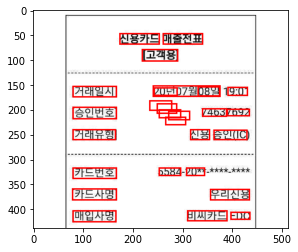

In [5]:
# model version
version = "v2"

# test image file path
image_file_path = "./sample_images/detection/1594202471809.jpg"
#image_file_path = "./sample_images/detection/1596537103856.jpeg"
#image_file_path = "./sample_images/video_frames/frame000000.png"

# set model conf file path and mode weight file path
# prefixed by ./model/[detection|recognition]
config_file = os.path.join('./model/detection', detect_model[version]["config_file"])
weight_file = os.path.join('./model/detection', detect_model[version]["weight_file"])

# clone project level config and merge with experiment config
cfg = cfg.clone()
cfg.merge_from_file(config_file)

# Detection model object creation
demo = DetectionDemo(cfg, weight_file)

# open image file as PIL.Image with RGB
pil_image = Image.open(image_file_path).convert('RGB')
org_pil_image = np.array(pil_image)
prediction = demo.run_on_pil_image(pil_image)


# draw with predicted boxes
bboxes = prediction['bboxes']
scores = prediction['scores']


bboxed_image, num_boxes = bb_image_draw(pil_image, line_color=(255, 0, 0), line_width = 3, score_threshold = 0.3)

# Display an image with Python
# https://stackoverflow.com/questions/35286540/display-an-image-with-python
plt.figure()
plt.imshow(bboxed_image)
plt.show()


# Model Inspection

Reference
* [Retrieve paramter list of module](https://discuss.pytorch.org/t/retrieve-paramter-list-of-module/106427)

Use python dunder method `__dict__` on any python object. If I instantiate conv2d module like this:

```python
conv2d = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
```
Calling conv2d.__dict__ gives me this:
```js
{'_backward_hooks': OrderedDict(),
 '_buffers': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_parameters': OrderedDict([('weight', Parameter containing:
               tensor([[[[-0.0343,  0.0877, -0.1922],
                         [-0.0998,  0.0335,  0.1608],
                         [-0.0976,  0.0042,  0.0078]],
               
                       ...
               
                        [[ 0.0101,  0.1680, -0.1120],
                         [-0.0862,  0.0624, -0.0306],
                         [ 0.0852, -0.0843, -0.0521]]]], requires_grad=True)),
              ('bias', Parameter containing:
               tensor([ 0.0879,  0.0465, -0.1899, -0.1272,  0.0014,  0.0306],
                      requires_grad=True))]),
 '_reversed_padding_repeated_twice': (0, 0, 0, 0),
 '_state_dict_hooks': OrderedDict(),
 'dilation': (1, 1),
 'groups': 1,
  'in_channels': 3,
 'kernel_size': (3, 3),
 'out_channels': 6,
 'output_padding': (0, 0),
 'padding': (0, 0),
 'padding_mode': 'zeros',
 'stride': (1, 1),
 'training': True,
 'transposed': False}
 ```

In [7]:
print(demo.model)

GeneralizedRCNN(
  (backbone): Sequential(
    (body): ResNet(
      (stem): StemWithFixedBatchNorm(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
      )
      (layer1): Sequential(
        (0): BottleneckWithFixedBatchNorm(
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
        )
        (1): BottleneckWithFixedBatchNorm(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): Fro

----


## nn.Module.named_children()

```nn.Module.named_children()``` 메소드는 ```nn.Module``` 클래스 오브젝트의 ``immediate children object```(타입: nn.Module )의 name 스트링과  children object 자체로 구성된 튜플에 대한 **iterator**를 리턴
> (string, Module) – Tuple containing a name and child module

In [8]:
for name, module in demo.model.named_children():
    print(f"name: {name}")

name: backbone
name: rpn


In [9]:
print(demo.model.backbone)

Sequential(
  (body): ResNet(
    (stem): StemWithFixedBatchNorm(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
    )
    (layer1): Sequential(
      (0): BottleneckWithFixedBatchNorm(
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d()
        )
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d()
      )
      (1): BottleneckWithFixedBatchNorm(
        (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stri

In [10]:
for name, module in demo.model.backbone.named_children():
    print(f"name: {name}")

name: body
name: fpn


In [11]:
for name, module in demo.model.backbone.body.named_children():
    print(f"name: {name}")

name: stem
name: layer1
name: layer2
name: layer3
name: layer4


In [12]:
for name, module in demo.model.backbone.body.stem.named_children():
    print(f"name: {name}")

name: conv1
name: bn1


In [13]:
print(demo.model.backbone.body.stem)

StemWithFixedBatchNorm(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): FrozenBatchNorm2d()
)


In [14]:
demo.model.backbone.body.stem.conv1.__dict__

{'training': False,
 '_parameters': OrderedDict([('weight',
               Parameter containing:
               tensor([[[[ 2.8253e-02,  1.8187e-02,  1.5885e-02,  2.4201e-03, -5.3015e-02,
                          -4.7356e-02,  1.8543e-02],
                         [ 7.9901e-03,  2.4886e-02,  7.6726e-02,  9.0264e-02, -1.8915e-02,
                          -7.9356e-02, -1.5362e-02],
                         [-2.7473e-02, -6.5754e-02,  1.9992e-02,  1.8476e-01,  1.1553e-01,
                          -8.9980e-02, -9.4645e-02],
                         [-9.7877e-03, -7.9237e-02, -1.2982e-01,  9.5236e-02,  2.7007e-01,
                           9.9407e-02, -1.4932e-02],
                         [ 2.3180e-02, -4.6452e-02, -1.8301e-01, -1.5604e-01,  5.3617e-02,
                           8.3496e-02,  3.6958e-02],
                         [ 4.2255e-02,  4.5947e-02, -4.6616e-02, -1.2704e-01, -2.1024e-02,
                           3.3222e-02,  2.5052e-02],
                         [ 1.4630e-02, 

In [15]:
demo.model.backbone.body.stem.conv1.__dict__.keys()

dict_keys(['training', '_parameters', '_buffers', '_backward_hooks', '_forward_hooks', '_forward_pre_hooks', '_state_dict_hooks', '_load_state_dict_pre_hooks', '_modules', 'in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'transposed', 'output_padding', 'groups', 'padding_mode'])

In [16]:
demo.model.backbone.body.stem.conv1._buffers.keys()

odict_keys([])

In [17]:
demo.model.backbone.body.stem.conv1._parameters.keys()

odict_keys(['weight', 'bias'])

In [18]:
demo.model.backbone.body.stem.conv1._parameters['weight']

Parameter containing:
tensor([[[[ 2.8253e-02,  1.8187e-02,  1.5885e-02,  2.4201e-03, -5.3015e-02,
           -4.7356e-02,  1.8543e-02],
          [ 7.9901e-03,  2.4886e-02,  7.6726e-02,  9.0264e-02, -1.8915e-02,
           -7.9356e-02, -1.5362e-02],
          [-2.7473e-02, -6.5754e-02,  1.9992e-02,  1.8476e-01,  1.1553e-01,
           -8.9980e-02, -9.4645e-02],
          [-9.7877e-03, -7.9237e-02, -1.2982e-01,  9.5236e-02,  2.7007e-01,
            9.9407e-02, -1.4932e-02],
          [ 2.3180e-02, -4.6452e-02, -1.8301e-01, -1.5604e-01,  5.3617e-02,
            8.3496e-02,  3.6958e-02],
          [ 4.2255e-02,  4.5947e-02, -4.6616e-02, -1.2704e-01, -2.1024e-02,
            3.3222e-02,  2.5052e-02],
          [ 1.4630e-02,  3.5230e-02,  4.1087e-03, -6.0385e-02, -1.7169e-02,
            1.1514e-02,  4.7915e-03]],

         [[ 5.8683e-03,  1.8755e-02,  3.6142e-02,  1.7155e-02, -9.3558e-02,
           -1.2410e-01, -2.6808e-02],
          [-7.6879e-03,  2.4297e-02,  1.4944e-01,  2.1562e-01,  

In [19]:
demo.model.backbone.body.stem.conv1._parameters.keys()

odict_keys(['weight', 'bias'])

In [20]:
demo.model.backbone.body.stem.bn1._buffers

OrderedDict([('weight',
              tensor([0.0148, 0.0233, 0.0220, 0.0509, 0.0200, 0.0110, 0.0179, 0.0307, 0.0233,
                      0.0352, 0.0138, 0.0243, 0.0213, 0.0125, 0.0157, 0.0160, 0.0132, 0.0092,
                      0.0363, 0.0093, 0.0179, 0.0169, 0.0113, 0.0284, 0.0175, 0.0095, 0.0223,
                      0.0515, 0.0167, 0.0206, 0.0144, 0.0283, 0.0252, 0.0378, 0.0092, 0.0267,
                      0.0248, 0.0208, 0.0085, 0.0105, 0.0161, 0.0571, 0.0132, 0.0225, 0.0219,
                      0.0092, 0.0211, 0.0151, 0.0337, 0.0196, 0.0117, 0.0142, 0.0396, 0.0148,
                      0.0248, 0.0193, 0.0311, 0.0207, 0.0090, 0.0228, 0.0219, 0.0301, 0.0082,
                      0.0194], device='cuda:0')),
             ('bias',
              tensor([ 1.4817, -1.1068, -1.0516, -1.9037,  1.3326,  2.0699, -1.1251, -0.9784,
                      -2.6708,  1.7933,  1.7312,  1.8157,  1.9905,  5.2611,  1.4816,  3.3727,
                       2.9129,  0.7078,  2.5673,  0.6645, 

In [21]:
demo.model.backbone.body.stem.bn1._buffers.keys()

odict_keys(['weight', 'bias', 'running_mean', 'running_var'])

In [22]:
buffers_dict = demo.model.backbone.body.stem.bn1._buffers
keys_in_stem1_bn1 = buffers_dict.keys()
for k in keys_in_stem1_bn1:
    print(f"{k}: {buffers_dict[k].shape}")

weight: torch.Size([64])
bias: torch.Size([64])
running_mean: torch.Size([64])
running_var: torch.Size([64])


In [23]:
demo.model.backbone.body.stem.bn1._buffers['weight']

tensor([0.0148, 0.0233, 0.0220, 0.0509, 0.0200, 0.0110, 0.0179, 0.0307, 0.0233,
        0.0352, 0.0138, 0.0243, 0.0213, 0.0125, 0.0157, 0.0160, 0.0132, 0.0092,
        0.0363, 0.0093, 0.0179, 0.0169, 0.0113, 0.0284, 0.0175, 0.0095, 0.0223,
        0.0515, 0.0167, 0.0206, 0.0144, 0.0283, 0.0252, 0.0378, 0.0092, 0.0267,
        0.0248, 0.0208, 0.0085, 0.0105, 0.0161, 0.0571, 0.0132, 0.0225, 0.0219,
        0.0092, 0.0211, 0.0151, 0.0337, 0.0196, 0.0117, 0.0142, 0.0396, 0.0148,
        0.0248, 0.0193, 0.0311, 0.0207, 0.0090, 0.0228, 0.0219, 0.0301, 0.0082,
        0.0194], device='cuda:0')

In [24]:
demo.model.backbone.body.stem.bn1._buffers['bias']

tensor([ 1.4817, -1.1068, -1.0516, -1.9037,  1.3326,  2.0699, -1.1251, -0.9784,
        -2.6708,  1.7933,  1.7312,  1.8157,  1.9905,  5.2611,  1.4816,  3.3727,
         2.9129,  0.7078,  2.5673,  0.6645,  1.6627,  1.6272,  5.4326, -1.5629,
         2.5127,  0.7179, -1.8516, -0.9266,  1.7487, -1.3773,  3.1648, -1.1697,
         1.7799, -0.3958,  2.3047, -1.4102,  1.5962, -2.0443,  2.4693,  2.9084,
         3.1007, -1.0367,  1.6090, -0.4187,  1.6284,  6.3339,  1.3542,  2.1521,
        -1.0271,  1.5339, -0.1386,  3.6346,  0.0963,  1.2332, -1.3480,  1.7105,
        -1.2960,  1.6665,  0.7627,  2.1636,  2.1586, -1.0185,  0.9681,  2.0116],
       device='cuda:0')

In [25]:
demo.model.backbone.body.stem.bn1._buffers['running_mean']

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [26]:
demo.model.backbone.body.stem.bn1._buffers['running_var']

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

In [27]:
demo.model.backbone.body.stem.bn1._buffers['running_var'].rsqrt()

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

----

## nn.Module.named_parameters()

```nn.Module.named_parameters()``` 메소드는 ```nn.Module``` 클래스 오브젝트의 ```Parameter``` object( 타입: ```nn.Parameter```)의 name 스트링과  Parameter 오브젝트 자체로 구성된 튜플에 대한 **iterator**를 리턴
> (string, Parameter) – Tuple containing the name and parameter



### torch.nn.parameter.Parameter class

Tensor 의 일종으로 module parameter로 취급된다.
```Parameter``` 클래스 는 ```Tensor``` 클래스의 서브클래스로 ```nn.Module```클래스에서 사용되는 경우, 특별한 특성을 가진다. 
* ```Parameter```를 ```Module``` 의 속성(attributes)으로 할당되면 자동으로 ```Module`` 의 ```parameter``` 리스트에 추가되며,
* ```parameters()``` 메소드의 리턴값인 iterator를 통하여 표시된다.

일반 ```Tesnor``` 클래스는 위와 같은 특성을 가지지 않는다. 이는 모델에서 RNN의 마지막 hidden state와 같은 일부 temporary state를 캐쉬하기 위한 것이다. Parameter와 클래스가 없다면, 이들 임시 상태들도 등록되어야 한다.

```Parameters 클래스```는 다음과 같이 `data` 속성으로 `Tensor` 인스턴스를 포함하고, `requires_grad`라는 속성을 통하여, gradient 계산 기능이 추가된 것으로 이해할 수 있다.
* data (Tensor) – parameter tensor.
* **requires_grad** (bool, optional) – if the parameter requires gradient (Default: True). 

See [Locally disabling gradient computation](https://pytorch.org/docs/stable/notes/autograd.html#locally-disable-grad-doc) for more details. 

In [28]:
itr = demo.model.backbone.body.stem.named_parameters()  # get iterator
for name, param in itr:
    print(f"name: {name}")
    print(f"param.size: {param.size()}")
    print(f"param.type: {param.type()}")
    #print(f"param: {param}")
    

name: conv1.weight
param.size: torch.Size([64, 3, 7, 7])
param.type: torch.cuda.FloatTensor


In [29]:
itr = demo.model.named_parameters()  # get iterator
for name, param in itr:
    print(f"name: {name}")
    print(f"\tparam.size: {param.size()}\n")
    

name: backbone.body.stem.conv1.weight
	param.size: torch.Size([64, 3, 7, 7])

name: backbone.body.layer1.0.downsample.0.weight
	param.size: torch.Size([256, 64, 1, 1])

name: backbone.body.layer1.0.conv1.weight
	param.size: torch.Size([64, 64, 1, 1])

name: backbone.body.layer1.0.conv2.weight
	param.size: torch.Size([64, 64, 3, 3])

name: backbone.body.layer1.0.conv3.weight
	param.size: torch.Size([256, 64, 1, 1])

name: backbone.body.layer1.1.conv1.weight
	param.size: torch.Size([64, 256, 1, 1])

name: backbone.body.layer1.1.conv2.weight
	param.size: torch.Size([64, 64, 3, 3])

name: backbone.body.layer1.1.conv3.weight
	param.size: torch.Size([256, 64, 1, 1])

name: backbone.body.layer1.2.conv1.weight
	param.size: torch.Size([64, 256, 1, 1])

name: backbone.body.layer1.2.conv2.weight
	param.size: torch.Size([64, 64, 3, 3])

name: backbone.body.layer1.2.conv3.weight
	param.size: torch.Size([256, 64, 1, 1])

name: backbone.body.layer2.0.downsample.0.weight
	param.size: torch.Size([512, 

**주의 사항**

* `demo.model.named_parameter()` 가 리턴하는 iterator를 통해서는 `Conv2D` 타입의 레이어에 대한 weight 정보만을 확인할 수 있다.
* `FronzenBatchNorm2d` 타입의 레이어에 대한 정보는 `demo.model.named_buffer()`가 리턴하는 iteratory를 통해서 확인할 수있다.

----

## named_buffers() vs buffers()
`nn.Module.named_buffers()` 메소드는 `nn.Module` 클래스 오브젝트의 `buffer`(타입: torch.Tensor)의 `name` 스트링과  `buffer` 오브젝트로 구성된 튜플에 대한 **iterator**를 리턴

* (string, torch.Tensor) – Tuple containing the name and buffer

`nn.Module.buffers()` 메소드는 `nn.Module` 클래스 오브젝트 의 buffer(타입: torch.Tensor)에 대한 iterator를 리턴
* torch.Tensor – module buffer

**Note**

* Mask RCNN 소스상에서 `FrozenBatchNor2d`레이어는 learnable parameter를 buffer 타입으로 저장하므로, `named_buffers()` 메소드를 호출하여 iterator를 구한후 다음과 같이 확인할 수 있다.
  * weigtht
  * bias 
  * running_mean
  * runnging_var

### FrozenBatchNorm2d

mask rcnn에서 사용하는 FrozenBatchNorm2d 방식으로 구현할 것.
* [Why FrozenBatchNorm2d in ResNet?](http://echo.etri.re.kr:8090/pages/viewpage.action?pageId=78088692)
* https://github.com/facebookresearch/maskrcnn-benchmark/issues/267
* [Batch Normalization 설명 및 구현](http://echo.etri.re.kr:8090/pages/viewpage.action?pageId=78088844)
* [Batch Normalization 배치 정규화 꾸준희 블로그](https://eehoeskrap.tistory.com/430)
* [Normalization 정규화 설명](https://light-tree.tistory.com/132)


----

**Caffe BatchNorm vs PyTorch BatchNorm2d**

Reference: 
* [During test phase, the output of Batch Normalization layer is not equal to (input-mean)/sqrt(var + eps)?](https://github.com/BVLC/caffe/issues/4885)
* [why is FrozenBatchNorm2d used? -Confluence page](http://echo.etri.re.kr:8090/pages/viewpage.action?pageId=78087947)
> `net.params['bn_1'][0].data` : mean  
> `net.params['bn_1'][1].data` : variance   
> `net.params['bn_1'][2].data` : scores a scale factor, which I should divide from each mean and variance at this layer.    

So in Caffe, the output of BN layer calculated by: 

$
\begin{aligned}
\frac{ \frac{ \text{input} - \text{mean} }{ \text{scale_factor} }}
     { \sqrt { \frac{ \text{var }}{ \text{scale_factor } } + \epsilon}}
\end{aligned}
$

batchnorm 없이 scale 레이어로만해도  될듯...아래의 Mask RCNN에서 FronzenBatchNorm2d 클래스 구현을 보면 scale과 bias를 아래와 같이 구하고
* `scale =  self.weight * self.running_var.rsqrt()`
  * `self.running_var`는 모든 원소가 모두 1이고 shape는 weight (또는 bias)와 동일하므로 결국 `scale = self.weight`가 된다.
* `bias = self.bias - self.running_mean * scale` 
  * `self.running_mean`는 모든 원소가 모두 0이고 shape는 weight (또는 bias)와 동일하므로 결국 `bias = self. bias`가 된다.
각각 reshape해준 후, caffe scale layer의 동작에 해당하는 다음과 같은 연산 결과를 리턴한다.
* `x * scale + bias`
 * `scale = self.weight` 이고, `bias = self.bias`가 되므로 리턴값은 `x * self.weight + self.bias`가 된다.
 
 

따라서 Pytorch detection model의 FrozenBatchNorm의 parameter인 weight, bias, running_mean, running_var를 named_buffers()가 리턴하는 iterator를 통하여 구한후, 위의 계산을 해주어 scale, bias를 구하고 scale 레이어에 집어 넣어주면 될 것 같은데...


**Batch Norm Layer:**  
* gamma --> Var (1)   
* beta  --> mean (0)   
* mean  --> moving average fraction (=1)   

**Scale Layer:**
* scale --> 논문에서의 gamma   
* bias  --> 논문에서의 beta   


```python
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved.
import torch
from torch import nn
 
 
class FrozenBatchNorm2d(nn.Module):
    """
    BatchNorm2d where the batch statistics and the affine parameters
    are fixed
    """
 
    def __init__(self, n):
        super(FrozenBatchNorm2d, self).__init__()
        self.register_buffer("weight", torch.ones(n))
        self.register_buffer("bias", torch.zeros(n))
        self.register_buffer("running_mean", torch.zeros(n))
        self.register_buffer("running_var", torch.ones(n))
 
    def forward(self, x):
        # Cast all fixed parameters to half() if necessary
        if x.dtype == torch.float16:
            self.weight = self.weight.half()
            self.bias = self.bias.half()
            self.running_mean = self.running_mean.half()
            self.running_var = self.running_var.half()
 
        scale = self.weight * self.running_var.rsqrt()  # note that .rsqrt() is element-wise operation
        # scale = self.weight, since self.running_var has elelements of 1s of same shape with weight and bias.
        
        bias = self.bias - self.running_mean * scale
        # bais = self.bias, since self.running_mean has elements of 0s of same shape with weight and bias
        
        scale = scale.reshape(1, -1, 1, 1)
        bias = bias.reshape(1, -1, 1, 1)
        
        # hence technically, return value: x * self.weight + self.bias
        return x * scale + bias


### Difference between `register_buffer` and `register_parameter` of `nn.Module`


* [What is the difference between `register_buffer` and `register_parameter` of `nn.Module`](https://discuss.pytorch.org/t/what-is-the-difference-between-register-buffer-and-register-parameter-of-nn-module/32723)

**[Question by coincheung](https://discuss.pytorch.org/t/what-is-the-difference-between-register-buffer-and-register-parameter-of-nn-module/32723)**

> I was reading the code of mask-rcnn to see how they fix their `BatchNorm` parameters. I notice that they use `self.register_buffer()` to create the `weight` and `bias`, while, in the pytorch BN definition, `self.register_parameter` is used when `affine=True`. 
> Could I simply think that buffer and parameter have everything in common except that 
> * buffer will neglect the operations to compute grad and update its values ?
> 
>By the way, what is the different between directly defining a `nn.Paramter` in the module and using `register_parameter` ?

**[Answer by ptrblck](https://discuss.pytorch.org/t/what-is-the-difference-between-register-buffer-and-register-parameter-of-nn-module/32723/2)**
> Yes, you are correct in your assumption. 
> If you have parameters in your model, which should be saved and restored in the `state_dict`, but not trained by the optimizer, you should register them as buffers.
> `Buffers` won’t be returned in `model.parameters()`, so that the optimizer won’t have a change to update them.
> Both approaches work the same regarding training etc.
> There are some differences in the function calls however. 
> * Using `register_parameter()` you have to pass the name as a string, which can make the creation of a range of parameters convenient. 
> * Besides that I think it’s just coding style which one you prefer.

**[Answer by ptrblck](https://discuss.pytorch.org/t/what-is-the-difference-between-register-buffer-and-register-parameter-of-nn-module/32723/8)**
>As @pierrecurie explained, 
> one reason to register the tensor as a buffer is to be able to **serialize the model and restore all internal states**.
> Another one is that all buffers and parameters will be pushed to the device, if called on the parent model:
----

```python
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.my_tensor = torch.randn(1)
        self.register_buffer('my_buffer', torch.randn(1))
        self.my_param = nn.Parameter(torch.randn(1))
        
    def forward(self, x):
            return x


model = MyModel()
print(model.my_tensor)
> tensor([0.9329])

print(model.state_dict())
> OrderedDict([('my_param', tensor([-0.2471])), ('my_buffer', tensor([1.2112]))])

model.cuda()
print(model.my_tensor)
> tensor([0.9329])

print(model.state_dict())
> OrderedDict([('my_param', tensor([-0.2471], device='cuda:0')), ('my_buffer', tensor([1.2112], device='cuda:0'))]
```

----

> As you can see, model.my_tensor is still on the CPU, where is was created, while all parameters and buffers were pushed to the GPU after calling model.cuda().

----

# Model Parameter Save

## Conv2d parameters save

demo.model.named_parameters()가 return한 iterartor를 사용하여 param_name과 param그 자체를 구할 수 있다.
param은 [torch.nn.parameter.Parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) 클래스 타입으로 다음과 같은 필드를 포함하고 있다.
> `tensor` : paramter tensor   
> `device`: "cpu" or "cuda:0"  
> `requires_grad (bool)` : if the parameters requires gradient  

param들은 CUDA 장치의 메모리상에 있으므로, 다음과 같은 과정을 통하여 tensor의 내용을 numpy ndarray로 저장하여야 한다.   
> `requires_grad==True`로 설정된 tensor는 detach()를 호출후 numpy()를 호출하여야 한다.    
> `requires_grad==False`로 설정된 tensor는 cpu()를 호출후 numpy()를 호출하여야 한다.    

In [30]:
!rm ./npy_save/backbone*.npy
!rm ./npy_save/rpn*.npy

In [31]:
!ls -l ./npy_save/

total 6400
-rw-rw-r-- 1 kimkk kimkk 3317888 Sep  1 13:55 padded_tensor.npy
-rw-rw-r-- 1 kimkk kimkk 3231488 Sep  1 13:55 transformed_tensor.npy


In [32]:
def save_pytorch_model_learnable_parameters(model):
    
    #----------------------------------
    # learnable parameters of Conv2d
    #----------------------------------
    print("-"*80)
    print("saving learnalbe parameters of layers in detection v2 model")
    print("-"*80)
    itr = model.named_parameters()  # get iterator
    
    for param_name, param in itr:
        file_name = f"./npy_save/{param_name.replace('.', '_')}"
        
        if param.requires_grad:
            arr = param.detach().cpu().numpy()       
        else:
            arr = param.cpu().numpy()
    
        np.save(file_name, arr)
        print(f"{param_name} of {arr.shape}\n\t\tsaved in {file_name}")

In [33]:
save_pytorch_model_learnable_parameters(demo.model)

--------------------------------------------------------------------------------
saving learnalbe parameters of layers in detection v2 model
--------------------------------------------------------------------------------
backbone.body.stem.conv1.weight of (64, 3, 7, 7)
		saved in ./npy_save/backbone_body_stem_conv1_weight
backbone.body.layer1.0.downsample.0.weight of (256, 64, 1, 1)
		saved in ./npy_save/backbone_body_layer1_0_downsample_0_weight
backbone.body.layer1.0.conv1.weight of (64, 64, 1, 1)
		saved in ./npy_save/backbone_body_layer1_0_conv1_weight
backbone.body.layer1.0.conv2.weight of (64, 64, 3, 3)
		saved in ./npy_save/backbone_body_layer1_0_conv2_weight
backbone.body.layer1.0.conv3.weight of (256, 64, 1, 1)
		saved in ./npy_save/backbone_body_layer1_0_conv3_weight
backbone.body.layer1.1.conv1.weight of (64, 256, 1, 1)
		saved in ./npy_save/backbone_body_layer1_1_conv1_weight
backbone.body.layer1.1.conv2.weight of (64, 64, 3, 3)
		saved in ./npy_save/backbone_body_layer1_1

In [34]:
!ls -l ./npy_save

total 630492
-rw-rw-r-- 1 kimkk kimkk    16512 Sep  7 14:01 backbone_body_layer1_0_conv1_weight.npy
-rw-rw-r-- 1 kimkk kimkk   147584 Sep  7 14:01 backbone_body_layer1_0_conv2_weight.npy
-rw-rw-r-- 1 kimkk kimkk    65664 Sep  7 14:01 backbone_body_layer1_0_conv3_weight.npy
-rw-rw-r-- 1 kimkk kimkk    65664 Sep  7 14:01 backbone_body_layer1_0_downsample_0_weight.npy
-rw-rw-r-- 1 kimkk kimkk    65664 Sep  7 14:01 backbone_body_layer1_1_conv1_weight.npy
-rw-rw-r-- 1 kimkk kimkk   147584 Sep  7 14:01 backbone_body_layer1_1_conv2_weight.npy
-rw-rw-r-- 1 kimkk kimkk    65664 Sep  7 14:01 backbone_body_layer1_1_conv3_weight.npy
-rw-rw-r-- 1 kimkk kimkk    65664 Sep  7 14:01 backbone_body_layer1_2_conv1_weight.npy
-rw-rw-r-- 1 kimkk kimkk   147584 Sep  7 14:01 backbone_body_layer1_2_conv2_weight.npy
-rw-rw-r-- 1 kimkk kimkk    65664 Sep  7 14:01 backbone_body_layer1_2_conv3_weight.npy
-rw-rw-r-- 1 kimkk kimkk   131200 Sep  7 14:01 backbone_body_layer2_0_conv1_weight.npy
-rw-rw-r-- 1 kimkk kimk

----

## FronzenBatchNorm2d parameters save

FrozenBatchNorm2d 클래스에서는 다음과 같은 파라메터들을 
* `weight`
* `bias`
* `running_mean` : all elements are 1 and shape of weight.shape = bias.shape
* `running_var` : all elements are 1 and shape of weight.shape = bias.shape
training 시에 optimizer에 의하여 update하지 않고 고정된 값을 사용하기 위하여, `self.register_buffer()` 함수를 통하여 named buffer형태로 저장하고 있다. 

pycaffe Detection v2 모델에서는 `weight`와 `bias`만 필요하므로, 이들 값만 파일로 저장한다.

In [35]:
def save_pytorch_model_non_learnable_parameters(model):
    
    #----------------------------------
    # Fixed parameters of FrozenBatchNorm2d
    #----------------------------------
    print("\n\n")
    print("-"*80)
    print("saving non-learnalbe parameters of FrozenBatchNorm2d in detection v2 model")
    print("-"*80)
    itr = model.named_buffers()  # get iterator
    
    for buffer_name, buffer in itr:
        file_name = f"./npy_save/{buffer_name.replace('.', '_')}"
        t_list = buffer_name.split('.')
    
        if t_list[-1] == 'weight' or t_list[-1] == 'bias':
            
            # convert torch in cpu to numpy ndarray
            if buffer.requires_grad:
                arr = buffer.detach().cpu().numpy()               
                
            else:
                arr = buffer.cpu().numpy()
                
            np.save(file_name, arr)
            print(f"{buffer_name} of {arr.shape}\n\t\tsaved in {file_name}")
                
                

In [36]:
save_pytorch_model_non_learnable_parameters(demo.model)




--------------------------------------------------------------------------------
saving non-learnalbe parameters of FrozenBatchNorm2d in detection v2 model
--------------------------------------------------------------------------------
backbone.body.stem.bn1.weight of (64,)
		saved in ./npy_save/backbone_body_stem_bn1_weight
backbone.body.stem.bn1.bias of (64,)
		saved in ./npy_save/backbone_body_stem_bn1_bias
backbone.body.layer1.0.downsample.1.weight of (256,)
		saved in ./npy_save/backbone_body_layer1_0_downsample_1_weight
backbone.body.layer1.0.downsample.1.bias of (256,)
		saved in ./npy_save/backbone_body_layer1_0_downsample_1_bias
backbone.body.layer1.0.bn1.weight of (64,)
		saved in ./npy_save/backbone_body_layer1_0_bn1_weight
backbone.body.layer1.0.bn1.bias of (64,)
		saved in ./npy_save/backbone_body_layer1_0_bn1_bias
backbone.body.layer1.0.bn2.weight of (64,)
		saved in ./npy_save/backbone_body_layer1_0_bn2_weight
backbone.body.layer1.0.bn2.bias of (64,)
		saved in ./npy

In [ ]:
!ls ./npy_save/*bn*.npy